# Realistic Ocean Simulations in pure Julia

In this tutorial we will build a global ocean simulation using the ClimaOcean and Oceananigans Julia packages.
The simulation will be at a nominal one-degree with parameterizations for mesoscale eddies.
We will set up the grid, download and interpolate the bathymetry, 
download forcing files, and finally set up and run the simulation

### ***Bonus***
At the end of the tutorial we will change the resolution to allow the spontaneous generation of eddies and 
remove the eddy parameterization to see some beautiful ocean turbulence develop! (make sure to have GPU access
for this step!)


## Required software

The tutorial is quite computationally expensive, therefore, if you have 
access, it is recommended to run the tutorial on one GPU, otherwise:
- bla bla bla
- bla bla bla

## Packages:

Let's start by importing the necessary packages, these are:
- ClimaOcean: the ocean model
- Oceananigans: the fluid dynamics library doing the heavy lifting
- OrthogonalSphericalShellGrids: contains the constructor for the Tripolar grid we will use in the tutorial
- Printf: always useful for spitting out output
- CairoMakie: visualization package to visualize the results

In [1]:
using ClimaOcean
using Oceananigans
using Oceananigans.Units
using OrthogonalSphericalShellGrids
using Printf
using CairoMakie

┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   SpecialFunctionsExt [1285c0f1-ff9f-5867-b66e-0f359bcf09ba]
│   TiledIteration [06e1c1a7-607b-532d-9fad-de7d9aa2abac]
│   StaticArrayInterface [0d7ed370-da01-4f52-bd93-41d350b8b718]
│   KernelAbstractions [63c18a36-062a-441e-b654-da1e3ab1ce7c]
│   LoopVectorization [bdcacae8-1622-11e9-2a5c-532679323890]
│   OrthogonalSphericalShellGrids [c2be9673-fb75-4747-82dc-aa2bb9f4aed0]
│   ArrayInterfaceCUDAExt [f78586ac-ba87-5ec7-b3a5-84bc1b258ee3]
│   SLEEFPirates [476501e8-09a2-5ece-8869-fb82de89a1fa]
│   CloseOpenIntervals [fb6a15b2-703c-40df-9091-08a04967cfa9]
│   ClimaOcean [0376089a-ecfe-4b0e-a64f-9c555d74d754]
│   CUDA [052768ef-5323-5732-b1bb-66c8b64840ba]
│   VectorizationBase [3d5dd08c-fd9d-11e8-17fa-ed2836048c2f]
│   SparseArraysExt [85068d23-b5fb-53f1-8204-05c2aba6942f]
│   LayoutPointers [10f19ff3-798f-405d-979b-55457f8fc047]
│   AtomixCUDAExt [13011619-4c7c-5ef0-948f-5fc81565cd05]
│   CUDAExt [11b7e2e0-

# Building a Global Ocean domain

- problems with poles -> tripolar grid has a fold
- steps to build a grid
(1) architecture
(2) vertical coordinate
(2) grid
(3) bathymetry

### Architectures

using an architecture is easy...
it is possible to choose between:
<br>
(1) CPU 
<br>
(2) GPU 
<br>
(3) Distributed 

In this case, we select `CPU()`, which is always the right choice to start prototyping. 
Building the script on CPUs is better in terms of stacks and to catch potential bugs in the script. 
Once we know that everything works correctly, we can just change this line, and voilá, the simulation runs on GPUs or
multiple CPUs - GPUs!

In [2]:
arch = CPU();

### Vertical coordinates

Vertical coordinates are very important, bla, bla bla...
you can build your own or use one of the provided defaults.

In [3]:
depth = 6000meters
Nz    = 50
h     = 12

z_faces = ClimaOcean.exponential_z_faces(; Nz, h, depth)

# Let's check the maximum and minimum of the spacings
Δz = z_faces[2:end] .- z_faces[1:end-1]

50-element Vector{Float64}:
 487.28835961198456
 448.3269335748955
 412.4806911634705
 379.50055604739555
 349.15736694012685
 321.2402852799469
 295.5553302257458
 271.92403078812094
 250.1821857301038
 230.17872262073888
 211.77464811372147
 194.84208215712033
 179.26336942340686
   ⋮
  20.53620437137951
  18.89422012957408
  17.3835216989915
  15.993612045744797
  14.714833432435753
  13.538300311713364
  12.455837585366297
  11.459923799946267
  10.543638884218211
   9.70061606529353
   8.924997629336778
   8.211394219451238

# Building a grid

talk about the tripolar grid....

In [8]:
Nx = 40 # longitudinal direction -> 40 points is about 9ᵒ resolution
Ny = 20 # meridional direction -> same thing, 20 points is about 9ᵒ resolution

coarse_grid = TripolarGrid(arch; size = (Nx, Ny, 1))

@show coarse_grid # Note that the minimum horizontal spacings are much lower than 4ᵒ!!!!

# Let's visualize the grid

using OrthogonalSphericalShellGrids: get_cartesian_nodes_and_vertices

cartesian_nodes, _ = get_cartesian_nodes_and_vertices(coarse_grid, Face(), Face(), Center())
xF, yF, zF = cartesian_nodes

cartesian_nodes, _ = get_cartesian_nodes_and_vertices(coarse_grid, Center(), Center(), Center())
xC, yC, zC = cartesian_nodes

## Visualization

fig = Figure(size=(1200, 600))
axN = Axis3(fig[1, 1]; aspect=(1, 1, 1), elevation = +0.9, azimuth = 7, height=1500)
axS = Axis3(fig[1, 2]; aspect=(1, 1, 1), elevation = -0.9, azimuth = 7, height=1500)

for ax in (axN, axS)
    scale_factor = 0.98
    surface!(ax, xC .* scale_factor, yC .* scale_factor, zC .* scale_factor)
    wireframe!(ax, xC, yC, zC, color = :blue)    
    scatter!(ax, 0, 0, +1, color=:red, markersize=15)
    scatter!(ax, 0, 0, -1, color=:red, markersize=15)
    hidedecorations!(ax)
    hidespines!(ax)
end

display(fig)

LoadError: MethodError: no method matching length(::Oceananigans.Grids.StaticVerticalCoordinate{OffsetArrays.OffsetVector{Float64, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}, Float64})

[0mClosest candidates are:
[0m  length(::Any, [91m::Oceananigans.Grids.AbstractTopology[39m, [91m::Any[39m, [91m::Colon[39m)
[0m[90m   @[39m [35mOceananigans[39m [90m~/development/drakkar2025-demo-oceananigans/depot/packages/Oceananigans/LCTrr/src/Grids/[39m[90m[4mgrid_utils.jl:55[24m[39m
[0m  length(::Any, [91m::Oceananigans.Grids.AbstractTopology[39m, [91m::Any[39m, [91m::UnitRange[39m)
[0m[90m   @[39m [35mOceananigans[39m [90m~/development/drakkar2025-demo-oceananigans/depot/packages/Oceananigans/LCTrr/src/Grids/[39m[90m[4mgrid_utils.jl:56[24m[39m
[0m  length([91m::LLVM.ConstantArray[39m)
[0m[90m   @[39m [32mLLVM[39m [90m~/development/drakkar2025-demo-oceananigans/depot/packages/LLVM/wMjUU/src/core/value/[39m[90m[4mconstant.jl:421[24m[39m
[0m  ...


In [7]:
# Let's build a real one! 
# We need to integrate the z_faces 
Nx = 360 # longitudinal direction -> 360 points is about 1ᵒ resolution
Ny = 180 # meridional direction -> same thing, 180 points is about 1ᵒ resolution

# Do we want to use z★ coordinates? Just do:
z_faces = ZStarVerticalCoordinate(z_faces) 

underlying_grid = TripolarGrid(arch; size = (Nx, Ny, Nz), z = z_faces, halo = (7, 7, 4))

LoadError: MethodError: no method matching ZStarVerticalCoordinate(::ZStarVerticalCoordinate{Vector{Float64}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing})

[0mClosest candidates are:
[0m  ZStarVerticalCoordinate(::C, [91m::C[39m, [91m::D[39m, [91m::D[39m, [91m::E[39m, [91m::CC[39m, [91m::FC[39m, [91m::CF[39m, [91m::FF[39m, [91m::CC[39m, [91m::CC[39m) where {C, D, E, CC, FC, CF, FF}
[0m[90m   @[39m [35mOceananigans[39m [90m~/development/drakkar2025-demo-oceananigans/depot/packages/Oceananigans/LCTrr/src/Grids/[39m[90m[4mvertical_coordinate.jl:41[24m[39m
[0m  ZStarVerticalCoordinate([91m::Union{Tuple, AbstractVector}[39m)
[0m[90m   @[39m [35mOceananigans[39m [90m~/development/drakkar2025-demo-oceananigans/depot/packages/Oceananigans/LCTrr/src/Grids/[39m[90m[4mvertical_coordinate.jl:55[24m[39m
[0m  ZStarVerticalCoordinate([91m::Number[39m, [91m::Number[39m)
[0m[90m   @[39m [35mOceananigans[39m [90m~/development/drakkar2025-demo-oceananigans/depot/packages/Oceananigans/LCTrr/src/Grids/[39m[90m[4mvertical_coordinate.jl:56[24m[39m


# Adding a bathymetry to the grid

ClimaOcean provides a nifty utility to regrid the bathymetry over the grid, the `regrid_bathymetry` function

In [24]:
bottom_height = regrid_bathymetry(underlying_grid; minimum_depth=15, interpolation_passes=10, major_basins=2)

360×180×1 Field{Center, Center, Nothing} reduced over dims = (3,) on OrthogonalSphericalShellGrid on CPU
├── grid: 360×180×50 OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo and with precomputed metrics
├── boundary conditions: FieldBoundaryConditions
│   └── west: Periodic, east: Periodic, south: ZeroFlux, north: Zipper, bottom: Nothing, top: Nothing, immersed: Default
└── data: 374×194×1 OffsetArray(::Array{Float64, 3}, -6:367, -6:187, 1:1) with eltype Float64 with indices -6:367×-6:187×1:1
    └── max=0.0, min=-9057.31, mean=-2269.51

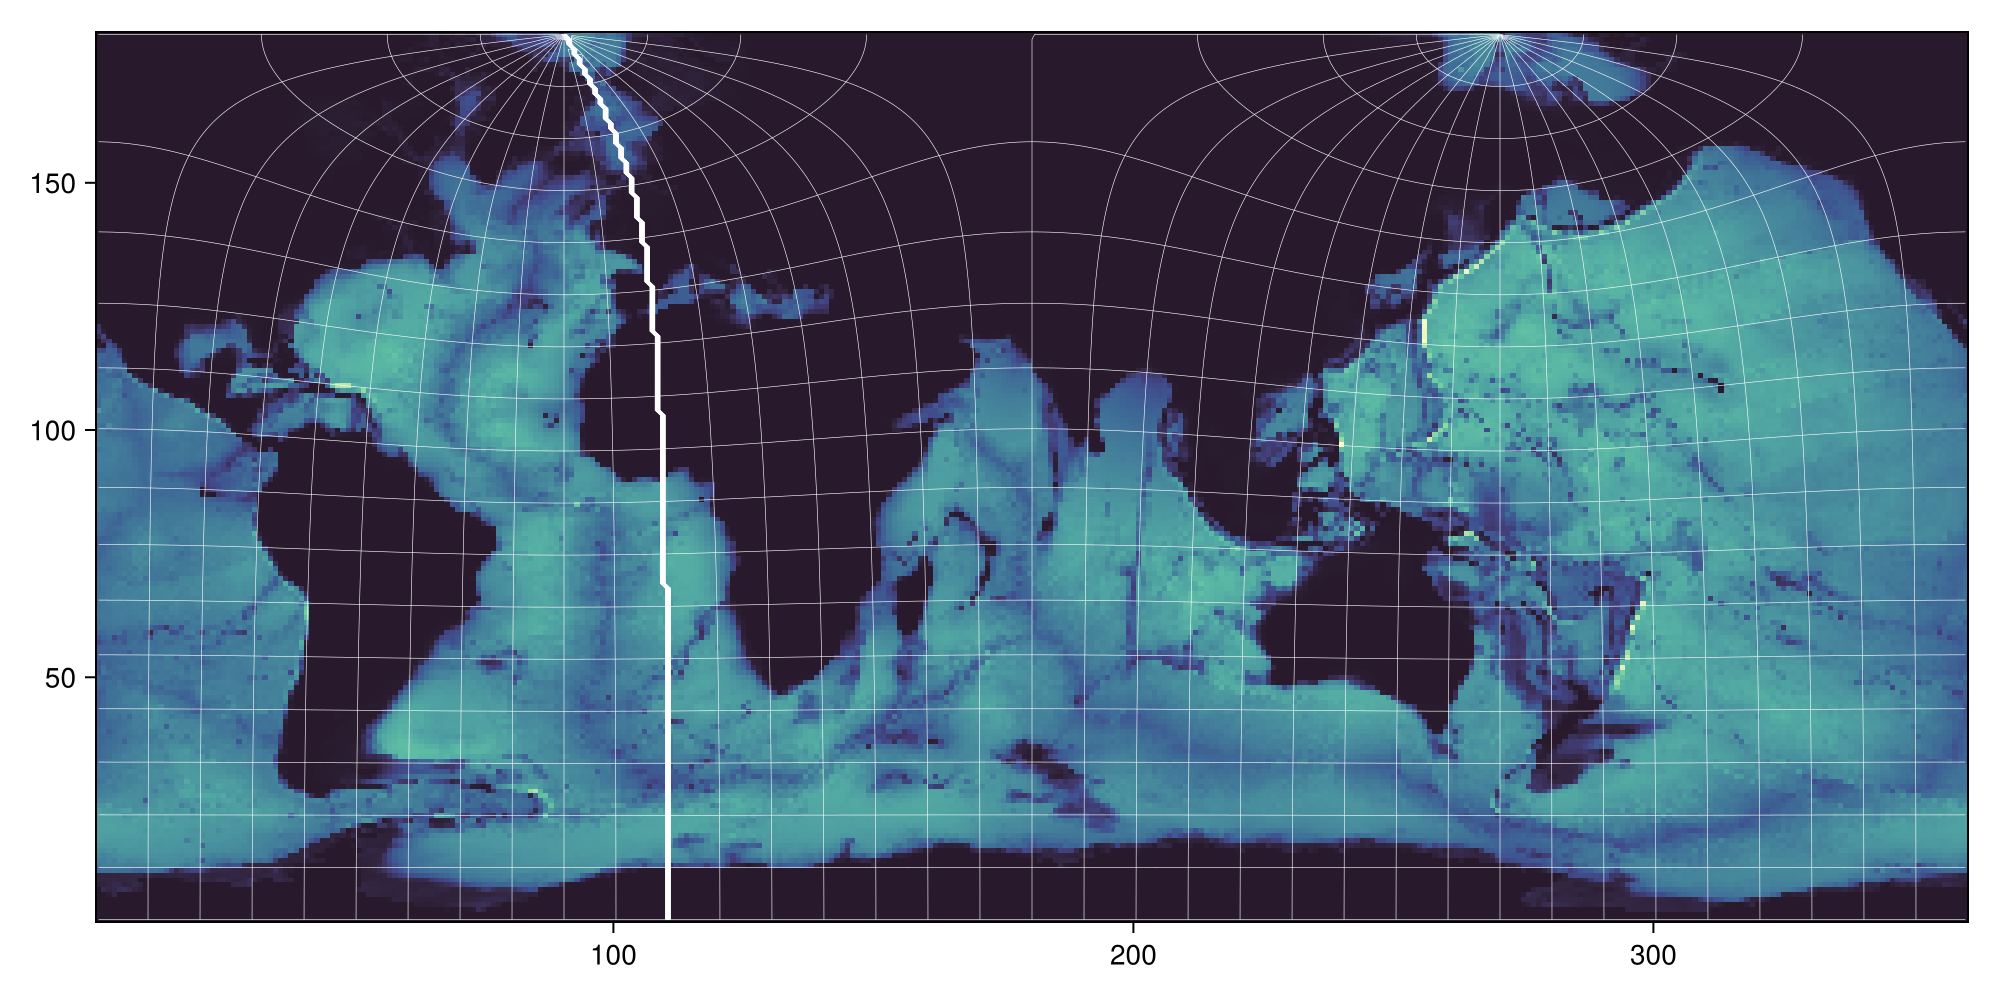

In [47]:
# Let's visualize the bathymetry
fig = Figure(size = (1000, 500))
ax  = Axis(fig[1, 1])
λ, φ, z = nodes(bottom_height)
heatmap!(ax, interior(bottom_height, :, : ,1), colormap=:deep)
contour!(ax, φ, levels=-80:10:90, color=:white, linewidth=0.3)
contour!(ax, λ, levels=0:10:360,  color=:white, linewidth=0.3)
display(fig);

In [26]:
grid = ImmersedBoundaryGrid(underlying_grid, GridFittedBottom(bottom_height); active_cells_map=true)

360×180×50 ImmersedBoundaryGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo:
├── immersed_boundary: GridFittedBottom(mean(z)=-2267.22, min(z)=-6000.0, max(z)=0.0)
├── underlying_grid: 360×180×50 OrthogonalSphericalShellGrid{Float64, Periodic, Oceananigans.Grids.RightConnected, Bounded} on CPU with 7×7×4 halo and with precomputed metrics
├── centered at (λ, φ) = (70.0, 1.8005)
├── longitude: Periodic  extent 360.162 degrees                          variably spaced with min(Δλ)=0.00753834, max(Δλ)=1.05373
├── latitude:  Oceananigans.Grids.RightConnected  extent 170.944 degrees variably spaced with min(Δφ)=0.0113516, max(Δφ)=0.949721
└── z:         Bounded  z ∈ [-6000.0, 0.0]                               variably spaced with min(Δz)=8.21139, max(Δz)=487.288

Oceananigans stores a map of "active cells" to avoid performing computions in "immersed cells".
<br>
This very simple "trick" is one of the secrets of the performance of Oceananigans


In [30]:
active_cells = map(Tuple{Int, Int, Int}, grid.interior_active_cells)

1664095-element Vector{Tuple{Int64, Int64, Int64}}:
 (87, 22, 1)
 (270, 23, 1)
 (88, 24, 1)
 (269, 24, 1)
 (86, 26, 1)
 (87, 26, 1)
 (84, 27, 1)
 (85, 27, 1)
 (59, 34, 1)
 (60, 34, 1)
 (61, 34, 1)
 (62, 34, 1)
 (63, 34, 1)
 ⋮
 (283, 180, 50)
 (284, 180, 50)
 (285, 180, 50)
 (286, 180, 50)
 (287, 180, 50)
 (290, 180, 50)
 (291, 180, 50)
 (292, 180, 50)
 (293, 180, 50)
 (295, 180, 50)
 (296, 180, 50)
 (297, 180, 50)

In [28]:
length(active_cells) / (Nx * Ny * Nz)

0.5136095679012346

# Building an ocean simulation

Several ingredients enter an ocean simulation, the main 3 are
- Numerics
- Parameterizations
- Forcing

let's start with the Numerics

## Numerics

Oceananigans is a staggered C-grid, with a z vertical coordinate, this cannot be changed...
<br>
The hydrostatic model solves the primitive equations, this, also cannot be changed...
<br>
however, how to express these equations on the staggered C-grid is left to the user, there are many many options! 
Some good, some a bit less...
<br>
In particular, let's look at 3 different aspects:
<br>
(1) ***Advection***
<br>
(2) ***Free surface***
<br>
(3) ***Time stepper***